# Life history traits model  26

Taylor Chapter 3  
model to describe age-structured life history traits of understudied Carcharhinid species

Model versions: mixed effects model describing maturity curves with a suite of other life history traits.  Model does not converge when input data has grey sharpnose or spadenose sharks included, maybe becuase they mature too early.  

This one is for Aaron to play with. 

### Set up notebook

In [73]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [75]:
# change directory
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'species_level_traits_v1.xlsx',
 'tmp_car_traits.csv',
 'tmp_car_traits.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data  

full_dataset contains maturity ogives scavenged from stock assessments and papers, with matching covariates for other life history traits. full_dataset_nosharpnoses has the same data but wihtout the troublesome short-lived sharpnose species that broke the previous model.  stock codes for these ones are GSH-I-17, MLK-I-17 and SPD-I-19

In [79]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]

In [5]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete'],
      dtype='object')

In [80]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(560, 37)

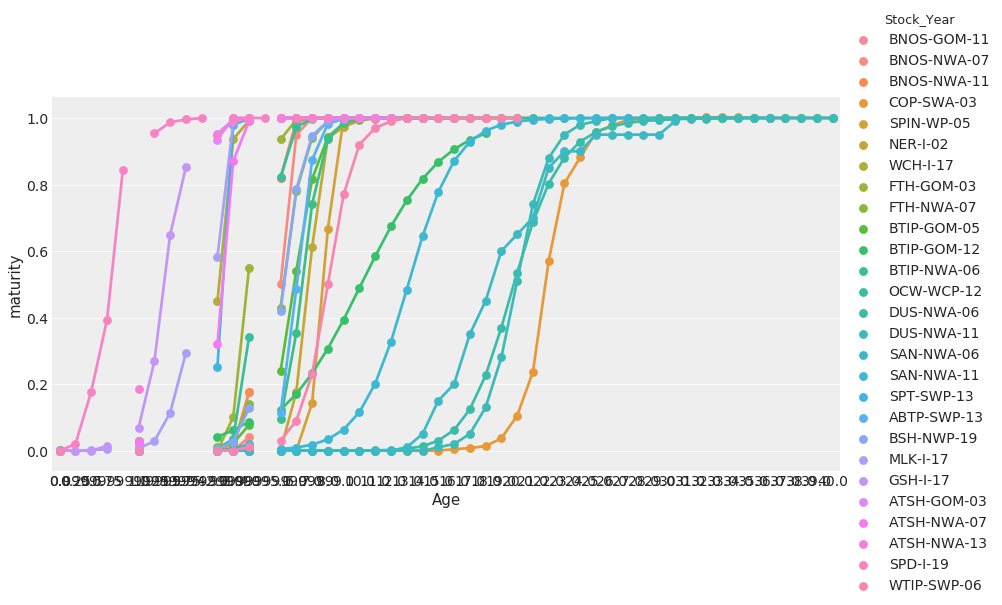

In [81]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [82]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [83]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'COP-SWA-03',
 'SPIN-WP-05',
 'NER-I-02',
 'WCH-I-17',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'OCW-WCP-12',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPT-SWP-13',
 'ABTP-SWP-13',
 'BSH-NWP-19',
 'MLK-I-17',
 'GSH-I-17',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'SPD-I-19',
 'WTIP-SWP-06']

In [84]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
#ROFFSZ = mdata.relative_offspring_size.values[Sind]
LITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]
DEPMAX = mdata.depth_max.values[Sind]
TEMP = mdata.temp_pref.values[Sind]

In [85]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
LITT = stdise(LITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)
DEPMAX = stdise(DEPMAX)
TEMP = stdise(TEMP)


### Model Specification

In [86]:
# random effects model with all covariates
with pm.Model() as mat1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0.5, 30) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
#    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
#    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
    β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    β12 = pm.Normal('Temperature', 0, 3)
    
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('S_', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
 #   B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
 #   B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
 #   B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
 #   B8 = pm.Normal('Litter-S', 0, 3)
 #   B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
 #   B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β4*K +  β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β11*LMAT + β12*TEMP)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B7*AMAX + B10*TROPH + B12*TEMP)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [87]:
# Sampling
# go back to 5000 for final run
with mat1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, Depth-S, Lmax-S, S_, S_sigma, GS, Temperature, Lmat, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, Depth, Lmax, a50_, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20683 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=UserWarning)

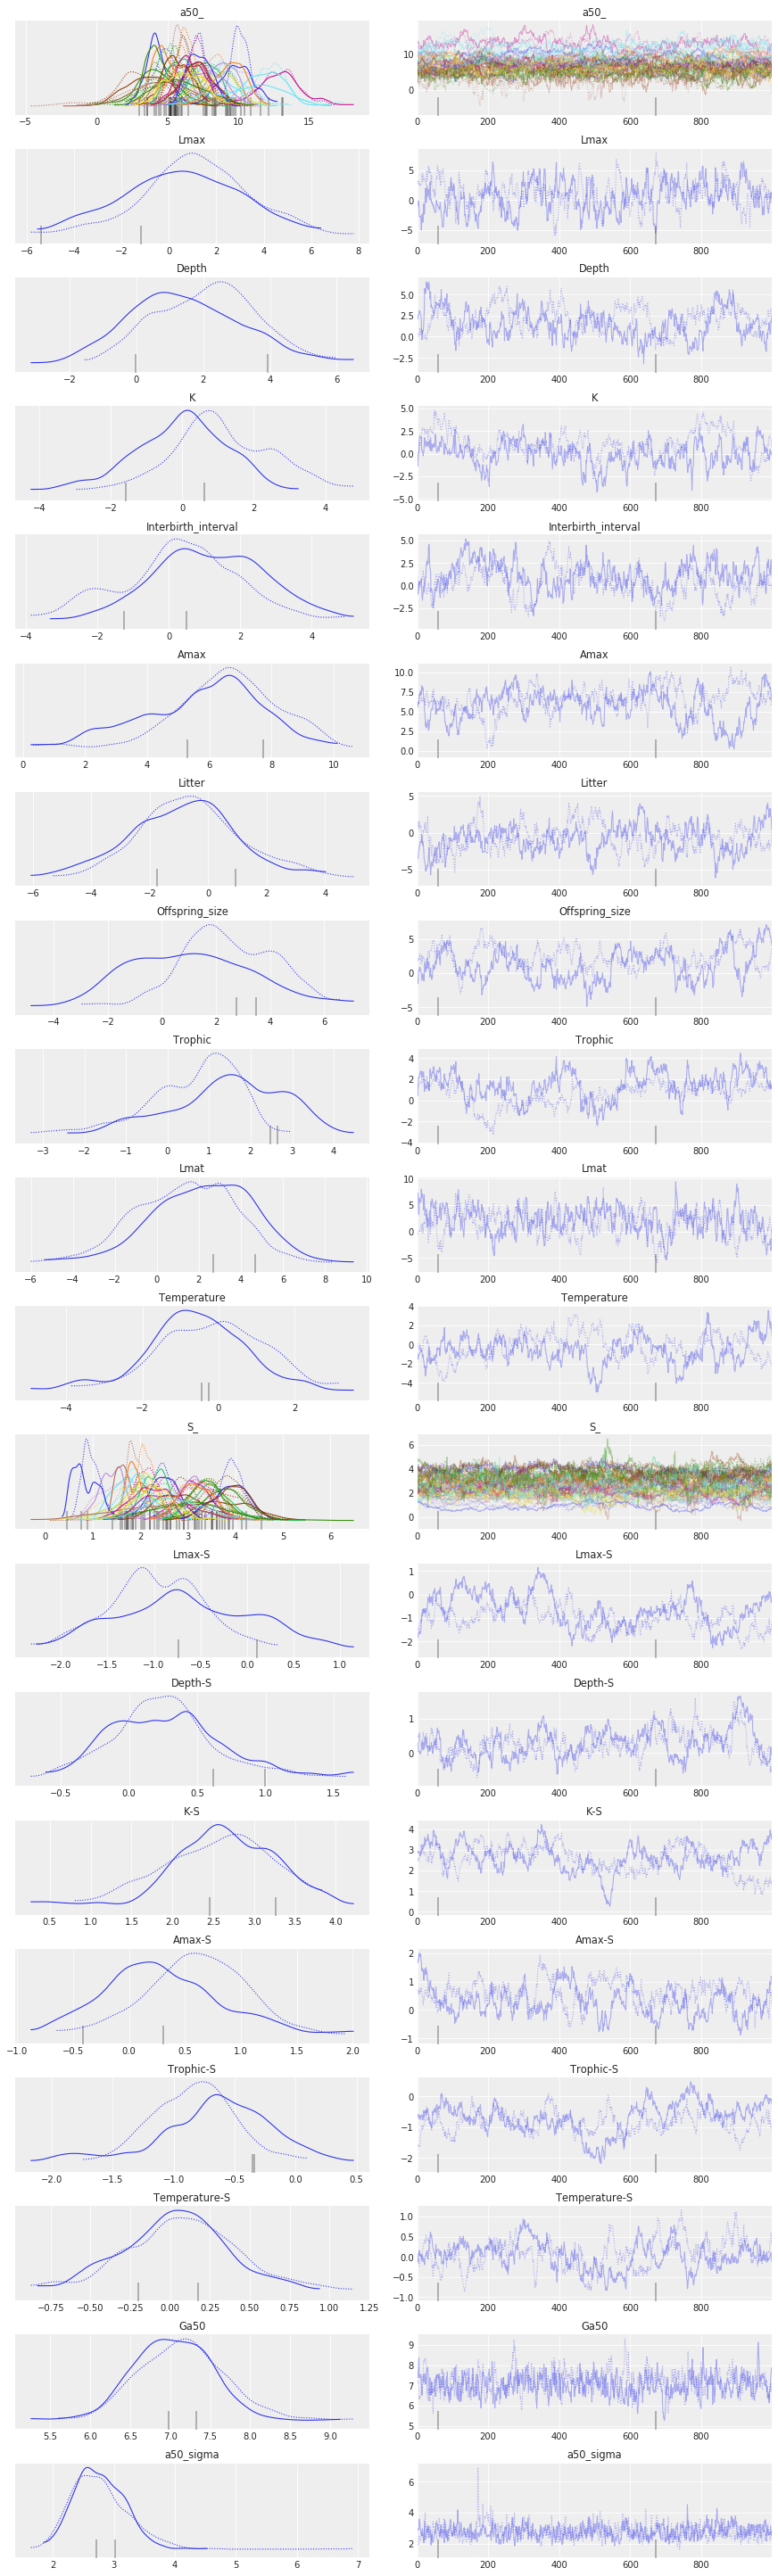

In [88]:
#check model performance
pm.traceplot(trace1);

In [89]:
pm.summary(trace1)
# looking for r-hat valeus of 1 - shows that model is converging
# value of 1.4 is too high

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a50_[0],4.582,0.915,3.037,6.463,0.203,0.149,20.0,20.0,22.0,63.0,1.10
a50_[1],5.261,1.042,3.550,7.293,0.337,0.246,10.0,10.0,10.0,74.0,1.22
a50_[2],4.766,1.042,3.052,6.789,0.337,0.246,10.0,10.0,10.0,73.0,1.22
a50_[3],12.889,1.580,9.831,16.022,0.229,0.163,48.0,48.0,49.0,100.0,1.06
a50_[4],3.331,1.482,0.416,5.651,0.195,0.139,58.0,58.0,59.0,171.0,1.06
...,...,...,...,...,...,...,...,...,...,...,...
mu_S[23],2.672,0.082,2.526,2.831,0.001,0.001,3166.0,3156.0,3180.0,1694.0,1.00
mu_S[24],4.409,0.200,4.043,4.773,0.008,0.005,675.0,663.0,722.0,815.0,1.00
mu_S[25],6.720,0.181,6.378,7.056,0.003,0.002,3963.0,3963.0,3976.0,1429.0,1.00
mu_S[26],1.198,0.025,1.150,1.243,0.001,0.000,2117.0,2113.0,2113.0,1429.0,1.01


In [32]:
#Save traces for use in prediction
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
pm.save_trace(trace1)

'.pymc_16.trace'

### Model Results

In [1]:
# Forest plot to see size and direction of cov effects
az.plot_forest(trace1)
plt.axvline(0, linestyle=':')
plt.show()

NameError: name 'az' is not defined

### Model Comparison

In [91]:
#WAIC for model 1 (26)
pm.waic(trace1, scale='deviance')

Computed from 2000 by 560 log-likelihood matrix

              Estimate       SE
deviance_waic -3520.65   139.60
p_waic          138.70        -

There has been a warning during the calculation. Please check the results.

#### Look for 'bad' datapoints

In [92]:
loo1 = pm.loo(trace1, mat1)
loo1

Computed from 2000 by 560 log-likelihood matrix

         Estimate       SE
elpd_loo  1756.38    68.02
p_loo      142.64        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      503   89.8%
 (0.5, 0.7]   (ok)         19    3.4%
   (0.7, 1]   (bad)        28    5.0%
   (1, Inf)   (very bad)   10    1.8%

In [93]:
badpoints1 = mdata.iloc[loo1.pareto_k.values > 0.7]

### Plot model fit

In [94]:
# Save results to external file - mat1
result1 = pm.backends.tracetab.trace_to_dataframe(trace1)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
result1.to_csv('mat26_model_results.csv')
result1.head()

,a50___0,a50___1,a50___2,a50___3,a50___4,a50___5,a50___6,a50___7,a50___8,a50___9,...,mu_S__18,mu_S__19,mu_S__20,mu_S__21,mu_S__22,mu_S__23,mu_S__24,mu_S__25,mu_S__26,S2
0,5.136366,5.241627,4.750297,13.811759,3.014600,10.043224,7.705788,8.162838,9.440188,6.225409,...,2.047473,1.576920,4.725855,5.868416,6.345292,2.734021,4.495866,6.828115,1.234077,0.009124
1,5.318339,5.397009,4.888598,13.292797,2.250906,10.332761,7.717317,7.850896,9.111955,6.158184,...,1.942336,1.562667,4.846926,5.717806,5.958343,2.611653,4.456600,6.705166,1.247303,0.008994
2,5.115615,5.136335,4.635806,13.519396,2.119786,9.948395,7.939057,7.652044,8.926136,6.204497,...,2.026399,1.655949,4.935872,5.687777,5.889434,2.739290,4.505564,6.805918,1.217322,0.009148
3,4.441634,4.872390,4.384672,12.950920,3.381707,9.149466,8.791393,8.166915,9.399861,6.473848,...,1.969444,1.599885,5.149770,5.770621,6.553681,2.594416,4.707030,6.904129,1.231790,0.009440
4,4.175762,4.718813,4.223494,13.102427,4.475507,8.245047,8.886311,8.187461,9.493712,6.293692,...,2.036274,1.664377,5.035225,5.684363,5.838133,2.714931,4.562587,6.841612,1.221106,0.009192


In [95]:
# Grab data from mat1 results (model 26)
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s = np.array([np.median(result1[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T

# can also just look at a50s (no effect of covariates)
a50s = np.array([np.median(result1[x]) for x in np.array(['a50___'+str(s) for s in list(range(len(StockYr)))])]).T

# Grab S's
μSs = np.array([np.median(result1[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss = np.array([np.median(result1[x]) for x in np.array(['S___'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

Text(0, 0.5, 'Proportion mature')

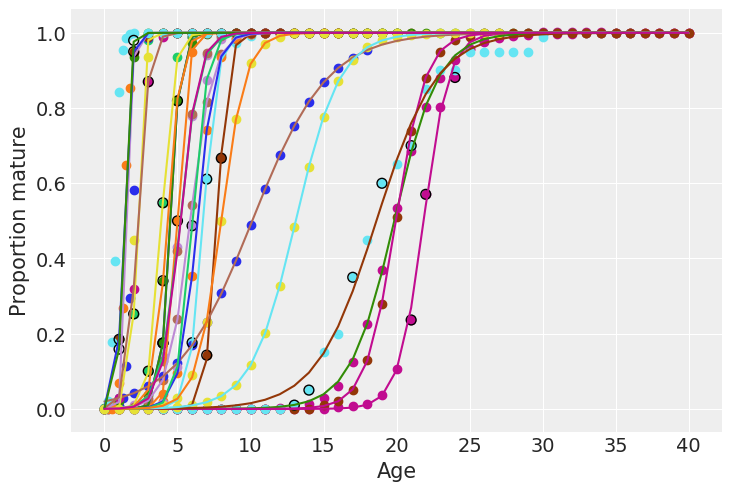

In [97]:
#plot model results against raw data - single plot model 1

#scatter plot of mat and age data
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
#plot ogives with median S and mu_a50 values
[plt.plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
# plot bad datapoints
plt.scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#make plot pretty
plt.xlabel('Age',fontsize=15)
plt.ylabel('Proportion mature',fontsize=15)